## Assumptions:

Aroon is a quite popular among technical analysts, it is supposed to detect trend reversals changes in asset prices.
I think that Aroon is too granular, espcially for low to mid float stocks with low market depth.
Detecting the convexity of the curved formed by successive prices (the line generated would be a polynomial fit) of low float stocks over an extended time period should give a better signal than Aroon.

In [1]:
import pandas as pd

import yfinance as yf
from talib import MA_Type
import talib
import numpy as np
from datetime import datetime, timedelta 
from time import gmtime, strftime
from csv import writer
import os
import sqlite3

from utils.db_manage import DBManager, QuRetType, dfToRDS, std_db_acc_obj
db_acc_obj = std_db_acc_obj() 


In [9]:
qu = f"SELECT * FROM marketdata.NASDAQ_15 WHERE DATE > '2017-01-01' AND Symbol ='KHC'"
initialDF = db_acc_obj.exc_query(db_name='marketdata', query=qu, \
retres=QuRetType.ALLASPD)
initialDF.to_csv('KHC.csv')


In [20]:
dfIDXG = pd.read_csv('IDXG.csv')

In [21]:
dfIDXG

,Unnamed: 0,Unnamed: 0.1,Symbol,Date,Open,High,Low,Close,Volume
0,1587,1587,IDXG,2020-07-02,5.10,6.640,4.7701,6.14,5352400
1,5038,5038,IDXG,2020-07-03,6.14,6.140,6.1400,6.14,0
2,8491,8491,IDXG,2020-07-06,6.38,6.800,5.6200,6.36,1220200
3,11945,11945,IDXG,2020-07-07,5.83,6.340,5.4500,5.53,419200
4,15403,15403,IDXG,2020-07-08,5.43,5.703,5.1100,5.19,259600
...,...,...,...,...,...,...,...,...,...
153,558385,558385,IDXG,2021-02-08,4.95,5.470,4.9300,5.29,264100
154,562432,562432,IDXG,2021-02-09,5.30,5.790,5.1900,5.70,295200
155,566493,566493,IDXG,2021-02-10,5.86,5.900,5.2900,5.44,165100
156,570556,570556,IDXG,2021-02-11,5.43,5.990,5.3900,5.61,226800


4.006860759493671
Equation:  0.000445761719799052*x**2 - 0.0786768388405201*x + 6.50880163303081


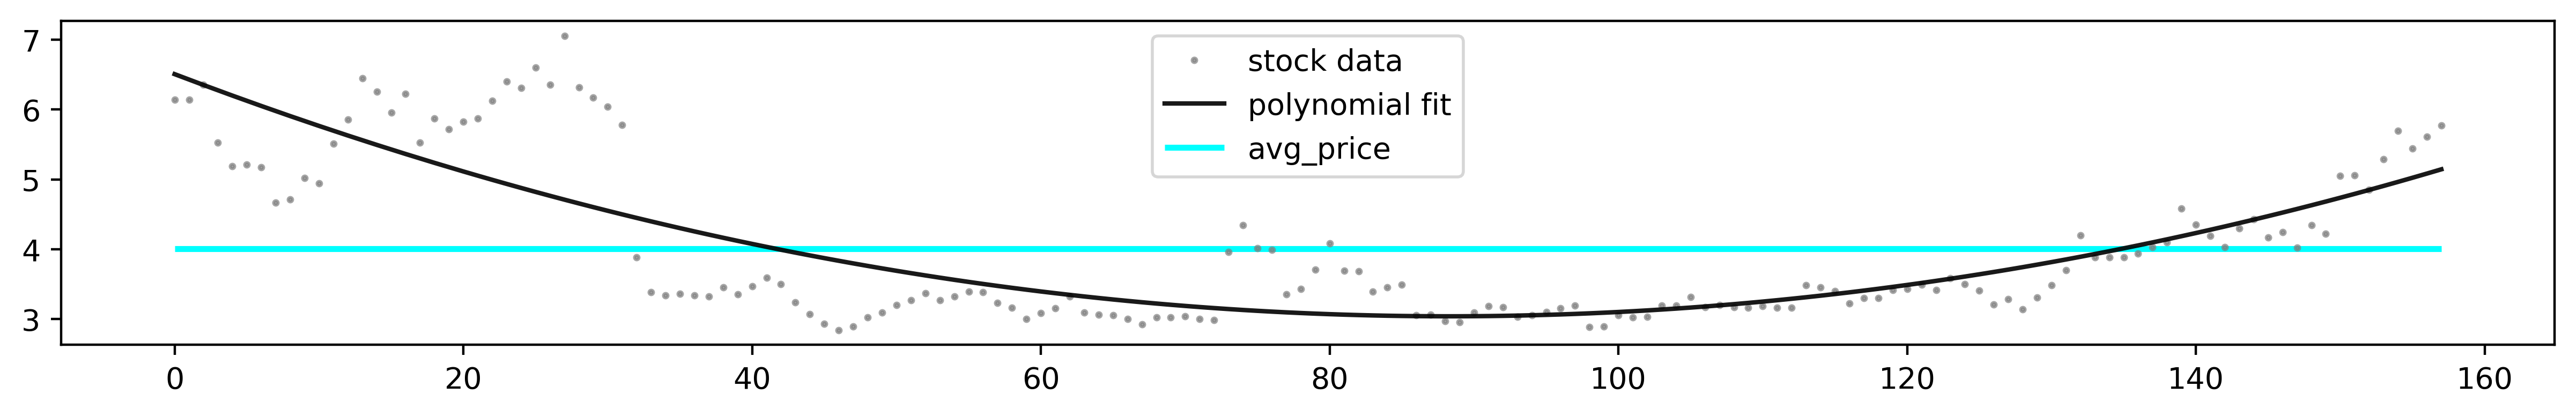

In [23]:

import matplotlib.pyplot as plt
from sympy import Symbol,expand

y_IDXG = dfIDXG.Close.tolist()
x_IDXG = range(len(y_IDXG))


avg_price = np.average(y_IDXG)
print(avg_price)

x = np.linspace(0, max(x_IDXG), max(x_IDXG) + 1)
# polynomial fit of degree xx
pol_IDXG = np.polyfit(x_IDXG, y_IDXG, 2)
y_pol_IDXG = np.polyval(pol_IDXG, x)


# Printing out the equation
y1_IDXG=np.poly1d(pol_IDXG)
eq_IDXG=Symbol('x')
print("Equation: ", expand(y1_IDXG(eq_IDXG)))


plt.figure(figsize=(15, 2), dpi= 400, facecolor='w', edgecolor='k')
plt.plot(x_IDXG, y_IDXG, 'o', markersize=1.5, color='grey', alpha=0.7)
plt.plot(x_IDXG, y_pol_IDXG, '-', markersize=1.0, color='black', alpha=0.9)
plt.hlines(y=avg_price, xmin=0, xmax=max(x_IDXG), colors='aqua', linestyles='-', lw=2, label='Single Short Line')
plt.legend(['stock data', 'polynomial fit', 'avg_price'])
plt.show()


# To do: assess the level of conexity on degree 2 or 3
# Set a threshold of convexity
# Assumption, the first point needs to be higher than the last one or start above the average price500000

Testing the equation:

In [24]:
x_IDXG= 80
fxIDXG = 0.000445761719799052*x_IDXG**2 - 0.0786768388405201*x_IDXG + 6.50880163303081
print("F(x): ", round(fxIDXG,2))

F(x):  3.07


<h4> The programmers method (the most intuitive first): </h4>




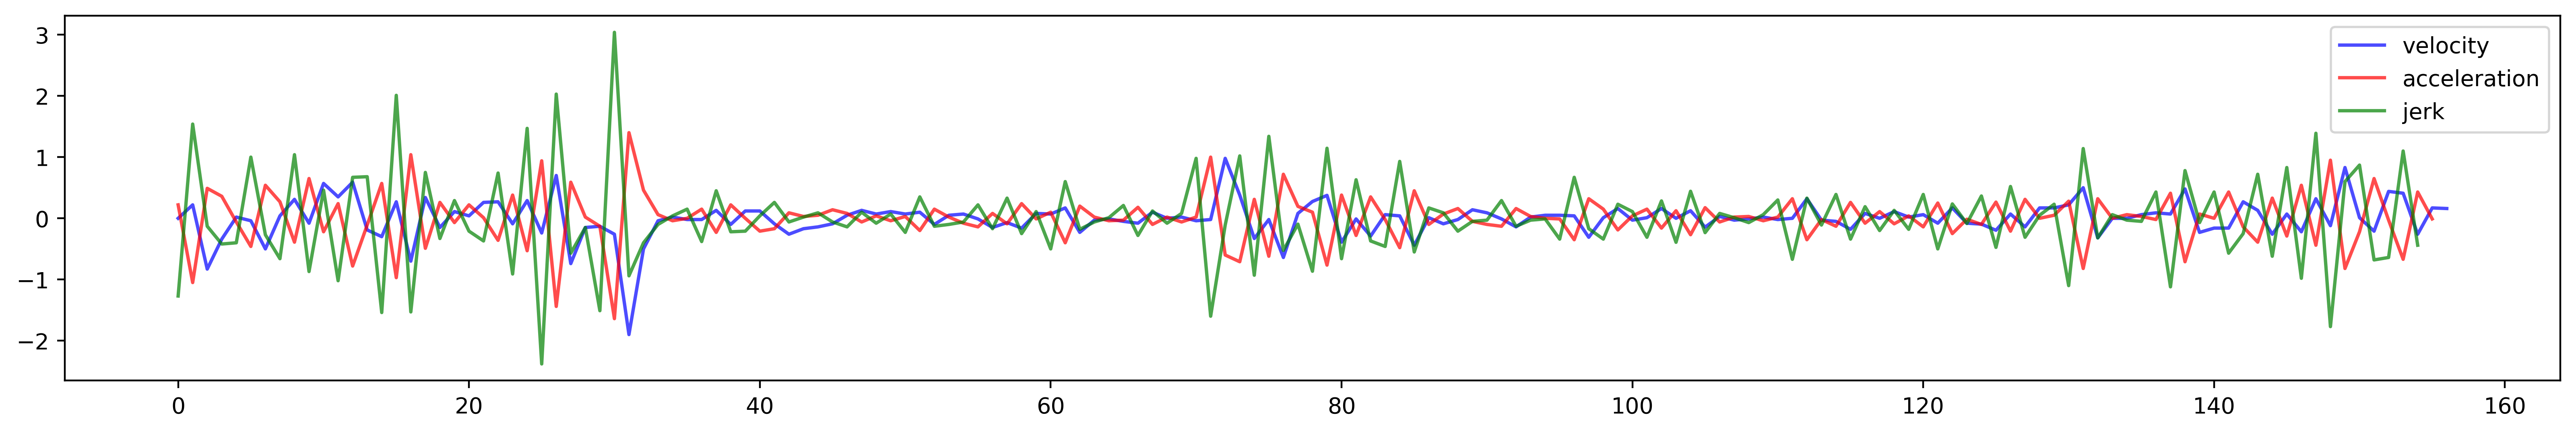

In [25]:
import numpy as np


velocity = np.diff(y_IDXG)
acceleration = np.diff(velocity)
jerk = np.diff(acceleration)
jounce = np.diff(jerk)


plt.figure(figsize=(20, 3), dpi= 400, facecolor='w', edgecolor='k')
plt.plot(list(range(len(velocity))), velocity, '-', markersize=1.5, color='blue', alpha=0.7)
plt.plot(list(range(len(acceleration))), acceleration, '-', markersize=1.5, color='red', alpha=0.7)
plt.plot(list(range(len(jerk))), jerk, '-', markersize=1.5, color='green', alpha=0.7)

plt.legend(['velocity', 'acceleration', 'jerk'])


"As a vector, jerk j can be expressed as the first time derivative of acceleration, second time derivative of velocity, and third time derivative of position:" <br>
Source: https://en.wikipedia.org/wiki/Jerk_(physics)

In [26]:
# positive numbers = rising
print("velocitiy: ", round(np.mean(velocity),4))

# positive numbers = concave up
print("acceleration: ", round(np.mean(acceleration),6))

# positive numbers = curling up
print("jerk: ", round(np.mean(jerk),4))

# positive numbers = snapping up
print("jounce: ", round(np.mean(jounce),4))


velocitiy:  -0.0024
acceleration:  0.001026
jerk:  -0.0015
jounce:  0.0054


Now, let's take a concave curve to prove and illlustrate this:

avg_price : 59.91
Equation IDXG:  0.000445761719799052*x**2 - 0.0786768388405201*x + 6.50880163303081
Equation PLUG:  -0.0876095843742904*x**2 + 3.05416844575669*x + 42.2451981981982


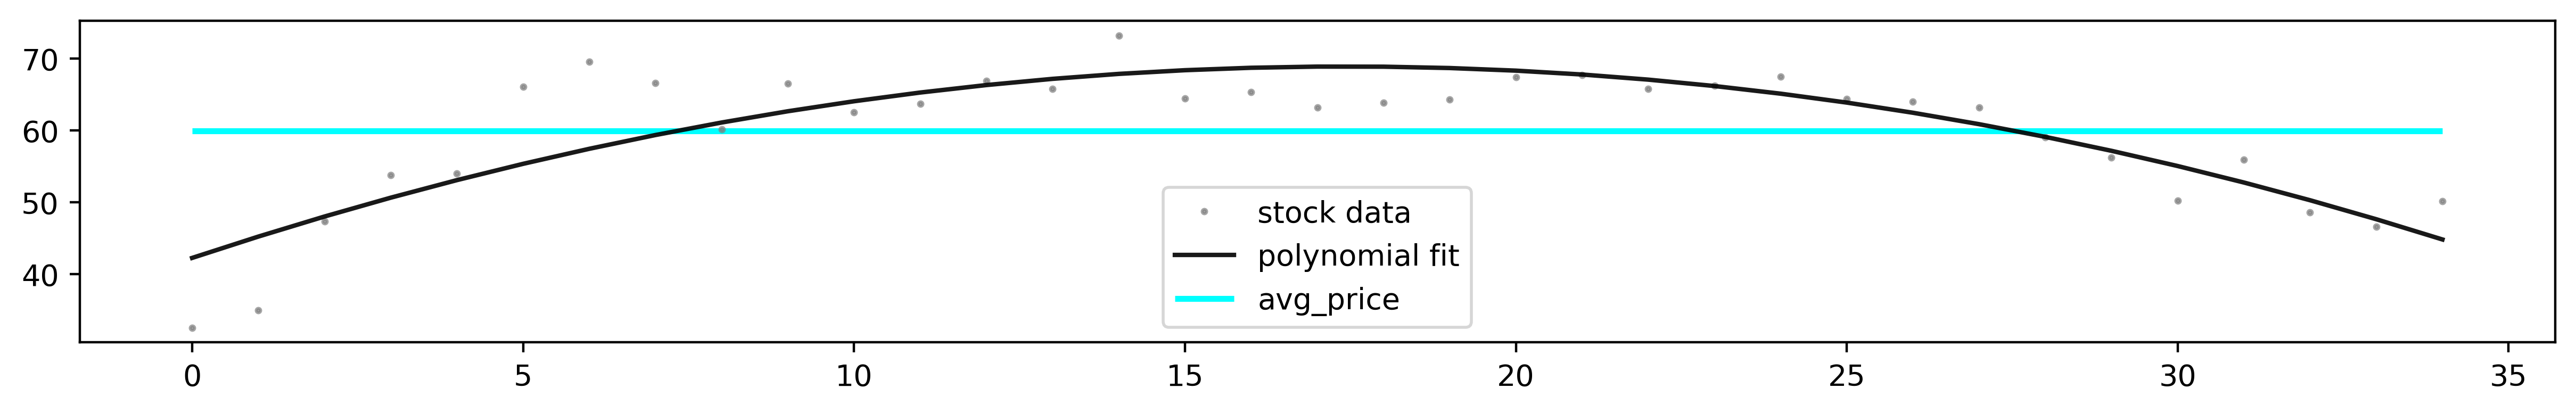

In [34]:
dfPLUG = pd.read_csv('PLUG.csv')


y_PLUG = dfPLUG.Close.tolist()
x_PLUG = range(len(y_PLUG))

avg_price = np.average(y_PLUG)
print('avg_price :', round(avg_price,2))

x = np.linspace(0, max(x_PLUG), max(x_PLUG) + 1)
# polynomial fit of degree xx
pol_PLUG = np.polyfit(x_PLUG, y_PLUG, 2)
y_pol_PLUG = np.polyval(pol_PLUG, x)


# Printing out the equation
y1_PLUG=np.poly1d(pol_PLUG)
eq_PLUG=Symbol('x')
print("Equation IDXG: ", expand(y1_IDXG(eq_IDXG)))
print("Equation PLUG: ", expand(y1_PLUG(eq_PLUG)))


plt.figure(figsize=(15, 2), dpi= 400, facecolor='w', edgecolor='k')
plt.plot(x_PLUG, y_PLUG, 'o', markersize=1.5, color='grey', alpha=0.7)
plt.plot(x_PLUG, y_pol_PLUG, '-', markersize=1.0, color='black', alpha=0.9)
plt.hlines(y=avg_price, xmin=0, xmax=max(x_PLUG), colors='aqua', linestyles='-', lw=2, label='Single Short Line')
plt.legend(['stock data', 'polynomial fit', 'avg_price'])
plt.show()


# To do: assess the level of conexity on degree 2 or 3
# Set a threshold of convexity
# Assumption, the first point needs to be higher than the last one or start above the average price500000

<b>A parabola with a non-negative leading coefficient is always convex.
This is indeed what we see for IDXG.</b>

In [28]:
# Simple test
x_PLUG= 15
fx = -0.0876095843742904*x_PLUG**2 + 3.05416844575669*x_PLUG + 42.2451981981982
print('F(x): ', round(fx,2))

F(x):  68.35


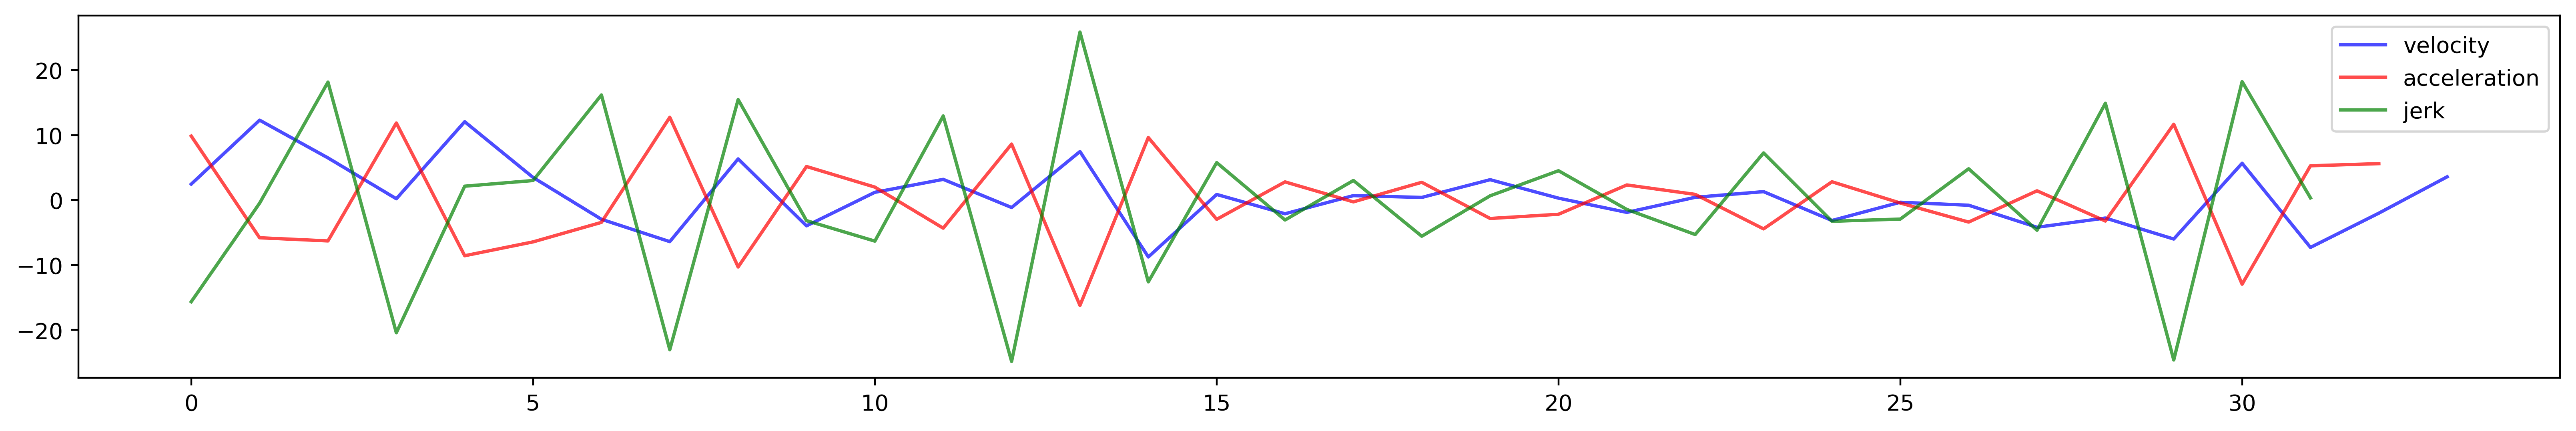

In [29]:
import numpy as np


velocity = np.diff(y_PLUG)
acceleration = np.diff(velocity)
jerk = np.diff(acceleration)
jounce = np.diff(jerk)

plt.figure(figsize=(20, 3), dpi= 400, facecolor='w', edgecolor='k')
plt.plot(list(range(len(velocity))), velocity, '-', markersize=1.5, color='blue', alpha=0.7)
plt.plot(list(range(len(acceleration))), acceleration, '-', markersize=1.5, color='red', alpha=0.7)
plt.plot(list(range(len(jerk))), jerk, '-', markersize=1.5, color='green', alpha=0.7)

plt.legend(['velocity', 'acceleration', 'jerk'])

In [30]:
print("velocitiy: ", round(np.mean(velocity),4))

print("acceleration: ", round(np.mean(acceleration),6))

print("jerk: ", round(np.mean(jerk),4))

print("jounce: ", round(np.mean(jounce),4))

velocitiy:  0.5179
acceleration:  0.034242
jerk:  -0.1325
jounce:  0.5153


<h4> The mathematicians method (second derivative to check for convexity): </h4>

<b> How to identify the 'level' of convexity? </b>

Intuitively there is no absolute level of convexity, or roundness. We need to compare a level of convexity on a same given timeframe and interval.

In [ ]:
dfPLUG = pd.read_csv('PLUG.csv')

import matplotlib.pyplot as plt
from sympy import Symbol,expand

y_KHC = dfKHC.Close.tolist()
x_KHC = range(len(y_KHC))


avg_price = np.average(y_KHC)
print(avg_price)

x = np.linspace(0, max(x_KHC), max(x_KHC) + 1)
# polynomial fit of degree xx
pol_KHC = np.polyfit(x_KHC, y_KHC, 2)
y_pol_KHC = np.polyval(pol_KHC, x)


# Printing out the equation
y1_KHC=np.poly1d(pol_KHC)
eq_KHC=Symbol('x')
print("Equation: ", expand(y1_KHC(eq_KHC)))


plt.figure(figsize=(15, 2), dpi= 400, facecolor='w', edgecolor='k')
plt.plot(x_KHC, y_KHC, 'o', markersize=1.5, color='grey', alpha=0.7)
plt.plot(x_KHC, y_pol_KHC, '-', markersize=1.0, color='black', alpha=0.9)
plt.hlines(y=avg_price, xmin=0, xmax=max(x_KHC), colors='aqua', linestyles='-', lw=2, label='Single Short Line')
plt.legend(['stock data', 'polynomial fit', 'avg_price'])
plt.show()


# To do: assess the level of conexity on degree 2 or 3
# Set a threshold of convexity
# Assumption, the first point needs to be higher than the last one or start above the average price500000